# Unit 10 - Graphs Part 2 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2022`__

Last week we introduced graphs and their applications. We looked at the specific challenges with parallelizing graph traversal and in particular the Single Source Shortest Path algorithm. In class today we'll look at another famous algorithm called PageRank which is an implementation of the Markov Chain, and which established Google as one of the world's most popular search engines.

By the end of this session, you will be able to:  

* ... __interpret__ the meaning of graph centrality metrics in the context of a specific problem or datset. (e.g. _the connection between eigenvector centrality and PageRank; bipartite graphs & recommender systems_.)
* ... __describe__ a transition matrix and stationary vector in the context of markov chains.
* ... __implement__ the power method to find the stationary vector.
* ... __identify__ the properties of a "well behaved" graph.
* ... __explain__ how the "random jump" adjustment makes the web graph both irreducible and aperiodic.


Time permitting...   
* ... __identify__ what chages need to be made to PR to implement Topic Specific PageRank
* ... __formulate__ the steps needed to implement TextRank (e.g. _how to convert unstructured text into a graph datastructure which can be fed to  the PageRank algorithm_. )
* ... __describe__ the relationship of *PageRank* to *PCA (Principal Components Analysis)* and *SVD (Singular Value Decomposition)*


## Notebook setup

In [1]:
# imports
import re
import heapq
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import scipy
import os
%matplotlib inline

In [2]:
# To shutdown Spark
# if Spark is not running no problem
# if Spark is running no problem also it will be shutdown
#  

try:
    spark
    print(f"{sc.master} appName: {sc.appName}")
    spark.sparkContext.stop()
    del spark; del sc
    print(f"Just Shutdown Spark.")
except NameError:
    print("Spark is NOT currently running")

Spark is NOT currently running


In [3]:
from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'Lab10_notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

ZONE = os.getenv("ZONE") #new as of June 17, 2022 4:45PM PST; restart cluster to see thus env variable
spark_UI_info = f'''
To start the SPARK UI

Copy the following command  to cloud shell and run as shown in the screenshot below. 
And click on the PREVIEW ON PORT 8080 menu option .
Run the following command to establish the SSH Tunnel:

gcloud compute ssh w261-m --zone {ZONE} --ssh-flag "-L 8080:localhost:4040" '''

print(spark_UI_info)

starting Spark
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5f2cf794-001f-456f-a54d-fea434f1cc19;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.1-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 259ms :: artifacts dl 6ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.1-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-----------------------------------------------


To start the SPARK UI

Copy the following command  to cloud shell and run as shown in the screenshot below. 
And click on the PREVIEW ON PORT 8080 menu option .
Run the following command to establish the SSH Tunnel:

gcloud compute ssh w261-m --zone us-central1-b --ssh-flag "-L 8080:localhost:4040" 


In [4]:
# Update scipy
!pip install -U networkx scipy

# Graph Centrality

__Identifying Special Nodes__ (Centrality): There are many ways to define what 'special' means, including metrics based on node in-degree, average distance to other nodes, and relationship to cluster structure. These special nodes are important to investigators attempting to break up terrorist cells, epidemiologists modeling the spread of diseases, advertisers trying to promote products, and many others. In particular, eigenvector centrality is used to find popular webpages using the PageRank algorithm, which in turn has been extended to Text summarization, Keyword extraction/Concept extraction using TextRank.

### A few examples of graph centrality measures

__Notation:__
The neighborhood of a vertex $v$ in graph $G$ is defined as a set of neighbors of a vertex $v$ and is denoted by $N(v)$. The neighborhood size is the number of immediate neighbors to a vertex. 

The number of edges between all neighbors of a vertex is denoted by $E(v)$. In the directed graph, the set of $N_{in}(v)$ is the set of vertices that point to a vertex $v$ (predecessors) and set of $N_{out}(v)$ is the set of vertices that vertex $v$ points to (successors).



#### Clustering coefficient
The clustering coefficient of a vertex measures the density of edges among the immediate neighbors of a vertex. It determines the probability of the presence of an edge between any two neighbors of a vertex. It is calculated as a ratio between the number of edges $E_i$ that actually exist among these and the total possible number of edges among neighbors: 

$$
c(v) = \frac{2E(v)}{|N(v)|(|N(v)|-1)}
$$


#### Degree Centrality
The degree $d(v)$ of a vertex 𝑣 is the number of edges at $v$; it is equal to the number of neighbors of $v$. The degree centrality $C_d(v)$ of a vertex $v$ is defined as the degree of the vertex. It can be normalized by dividing it by the maximum possible degree $N - 1$:

$$
C_d(v) = \frac{d(v)}{N-1}
$$

#### Betweenness centrality 
The betweenness centrality $C_b(v)$ of a vertex $v$ quantifies the number of times a vertex acts as a bridge along the shortest path between two other vertices. Let $\sigma_{out}$ be the number of the shortest paths from vertex $u$ to vertex $t$ and let $\sigma_{out}(v)$ be the number of those paths that pass through the vertex $v$. The normalized betweenness centrality of a vertex $v$ should be divided by the number of all possible edges in the graph and is given by:

$$
C_b(v) = \frac{2\sum_{v\ne u\ne t}\frac{\sigma_{ut}(v)}{\sigma_{ut}}}{(N-1)(N-2)}
$$

#### Closeness centrality 
In a connected graph, closeness centrality (or closeness) of a node is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes. When speaking of closeness centrality, people usually refer to its normalized form which represents the average length of the shortest paths instead of their sum. It is generally given by:

$$
C_{closeness}(v) = \frac{|V|}{\sum_u d(u,v)}
$$

where where $|V|$ is the number of vertices in the graph, and $d(u,v)$ is the distance between vertices $v$ and $u$. 


#### Eigenvector centrality   
The eigenvector centrality $C_{EV}(v)$ measures the centrality of a vertex $v$ as a function of the centralities of its neighbors. For the vertex $v$ and constant $\lambda$ it is defined:

$$
C_{EV}(v) = \frac{1}{\lambda} \sum_{u\in N(v)} C_{EV}(u)
$$

In the case of weighted networks, the equation can be generalized. Let $w_{uv}$ be the weight of edge between vertices $u$ and $v$ and $\lambda$ a constant. The eigenvector centrality of a vertex $v$ is given by:

$$
C_{EV}(v) = \frac{1}{\lambda} \sum_{u\in N(v)} w_{uv} \times C_E(u)
$$

The PageRank centrality is based on the eigenvector centrality measure and implements the concept of "voting". The PageRank score of a vertex $v$ is initialized to a default value and computed iteratively until convergence using the following equation:

$$
C_{pagerank}(v) = (1-d) + d \sum_{u \in N_{in}(v)} \frac {C_{PageRank}(u)}{|N_{out}(u)|}
$$
where $d$ is the damping factor set between 0 and 1 (usually set to 0.85).

 
__Sources__:   
https://www.researchgate.net/publication/280092953_An_Overview_of_Graph-Based_Keyword_Extraction_Methods_and_Approaches   
https://en.wikipedia.org/wiki/Centrality


# Background - From Random Walks to Markov Chains to PageRank

## The World Wide Web


There are over 4 billion internet users in 2019, and nearly 2 billion websites. Each of those websites can have multiple pages, and Google only crawls a fraction of them.

Wikipedia alone consists of almost 6 million articles, and nearly 50 million wiki pages.

Source of above stats: [https://www.websitehostingrating.com/internet-statistics-facts/](https://www.websitehostingrating.com/internet-statistics-facts/)


<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/google-index.png' style="width:50%;">


Source of above chart: [https://www.worldwidewebsize.com/](https://www.worldwidewebsize.com/)

### So how does Google decide which pages are "relevant"?
https://stanford.edu/~rezab/classes/cme323/S15/notes/lec7.pdf

The goal is to find a good metric for measuring the importance of each node (page) in the graph (corresponding to a ranking over the websites). A website’s importance will be measured by the number of sites that link to it. Ideally, we would like the amount of importance conferred on a website by receiving a link to be proportional to the importance of the website giving the link. (*the centrality of a vertex $v$ as a function of the centralities of its neighbors - see eignvector centrality definition above*)

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/beach.png' style="width:50%;">



We can formalize this intuition via the process of a random walk. We would like to model a __random surfer__ who is traversing the web with uniform probability of following any link outgoing from the page the surfer is currently on. We are intersted in the behavior of this random surfer in the limit as she takes an infinite number of jumps.


To express this in linear algebra, we will make use of the adjacency matrix, $A$, and a out-degree matrix $D$, where:

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/rezab-01.png' style="width:50%;">


Let $Q = D ^{-1} A$. This forms the transition matrix of the random-walker. Given the current state
of the walker each row of the matrix gives the probability the walker will transition to each new
state.

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/rezab-02.png' style="width:50%;">


It’s interesting to note that $Q^k_{ij}$ is equal to the probability of going from node $i$ to node $j$ in exactly $k$ steps, in a random walk over graph $G$. (The $k$ steps are the time-steps, not to be confused with hops (*paths*))

The __stationary distribution (or steady state)__ of the __Markov Chain__ with the transition probabilities defined by $Q$ is the solution to our PageRank problem as defined above. The stationary distribution can be interpreted as the proportion of time on average is spent at a specific state (page) during an infinitely long random walk.


# WAIT, WAT?
## A historical digression:

<table>
    <tr>
        <td><img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/220px-Jakob_Bernoulli-m.png' style="text-align:left;"></td>
        <td><img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/NekrasovPA-m.png' style="text-align:left;"></td>
        <td><img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/markov-coffee-m.png' style="text-align:left;"></td>
    </tr>
    <tr>
        <td style="text-align:left;width:33%;"><h3>Jacob Bernoulli</h3></td>
        <td style="text-align:left;width:33%;"><h3>Pavel Alekseevich Nekrasov</h3></td>
        <td style="text-align:left;width:33%;"><h3>Andrey Andreyevich Markov</h3></td>
    </tr>
    <tr>
        <td style="text-align:left;vertical-align:top;"><p>Jacob Bernoulli (also known as James or Jacques; 6 January 1655 – 16 August 1705) was one of the many prominent mathematicians in the Bernoulli family. Following his father's wish, he studied theology and entered the ministry. But contrary to the desires of his parents, he also studied mathematics and astronomy. </p>
            <ul>
                <li>Weak law of large numbers </li>
                <li>Central Limit theorem</li>
            </ul>
</td>
        <td style="text-align:left;vertical-align:top;"><p>Pavel Alekseevich Nekrasov (1853–1924) was a Russian mathematician and a Rector of the Imperial University of Moscow.</p></td>
        <td style="text-align:left;vertical-align:top;"><p>Andrey Andreyevich Markov (1856 – 1922) was a Russian mathematician best known for his work on stochastic processes. A primary subject of his research later became known as Markov chains and Markov processes. He was seen as a rebellious student by a select few teachers. In his academics he performed poorly in most subjects other than mathematics. Markov was an atheist. In 1912 he protested Leo Tolstoy's excommunication from the Russian Orthodox Church by requesting his own excommunication. The Church complied with his request.</p></td>
    </tr>
    <tr><td colspan="3">Source: <a href="https://en.wikipedia.org/wiki/Main_Page">Wikipedia</a></td></tr>
</table>

## The origin of the Markov Chain by Britt Cruise
https://www.khanacademy.org/computing/computer-science/informationtheory/moderninfotheory/v/markov_chains

Plato speculated that after an uncountable number of years, the universe will reach an ideal state, returning to its perfect form. But it wasn't until the 16th century that Bernoulli came along and refined the idea of expectation. He was focused on a method of accurately estimating the unknown probability of some event based on the number of times the event occurs in independent trials.
(pebbles in cups example). He went on to conclude "If observations of all events be continued for the entire infinity, it will be noticed that everything in the world is governed by precise ratios and a constant law of change." This became known as the weak __law of large numbers__.  This idea was quickly extended as it was noticed that not only did things converge on an expected average, but the probability of variation away from averages also follow a familiar, underlying shape, or distribution. This overall curvature, known as the binomial distribution, appears to be an ideal form as it kept appearing everywhere any time you looked at the variation of a large number of random trials (coin toss example). It seems the average fate of these events is somehow predetermined, known today as the __central limit theorem__.

This was a dangerous philosophical idea to some!

Nekrasov didn't like the idea of a predetermined statistical fate, and claimed that __Independence__ is a neccessary condition for the law of large numbers. Since independence just describes these toy examples using beans or dice, where the outcome of previous events doesn't change the probability of the current or future events. However, as we all can relate, most things in the physical world are clearly dependent on prior outcomes, such as the chance of fire or sun or even our life expectancy. When the probability of some event depends, or is conditional, on previous events, we say they are dependent events, or dependent variables.

This claim angered another Russian mathematician, Andrey Markov, who maintained a very public animosity towards Nekrasov. He goes on to say in a letter that "this circumstance prompts me to explain in a series of articles that the law of large numbers can apply to dependent variables", using a construction which he brags Nekrasov cannot even dream about! 

Markov extends Bernoulli's results to dependent variables using an ingenious construction. (*putting pebbles back into buckets depending on state*), and thus coining the __Markov property__. Let's explore what that looks like: 

### Discussion Question:
* What becomes steady? Do the states become steady? Does it mean that you will always be guaranteed to go from page i to page j?
* No - the state of the chain keeps jumping forever! What besomes steady, are the probailities.   
https://www.youtube.com/watch?v=IkbkEtOOC1Y marker 38:30

# Markov Chain via Power Iteration

## Recap:

* A __Markov chain__, named after Andrey Markov, is a  mathematical system that undergoes transitions  from one state to another, between a finite or  countable number of possible states.
* It is a __random process__ usually characterized as  __memoryless__: the next state depends only on the  current state and not on the sequence of events that preceded it.
* This specific kind of "memorylessness" is called  the __Markov property__. Markov chains have many  applications as statistical models of real-world  processes.
* A Markov chain consists of __state vector__ of dimension $n$ and an $n \times n$ transition __probability matrix__ $P$.
* At each time step $k$, we are in exactly one of the states.
* For 1 ≤ i,j ≤ n, the matrix entry $P_{ij}$ tells us the  probability of j being the next state, given we are  currently in state i.



### Let's look at an example "web graph" with nodes representing pages, and edges representing links:
<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/web-graph01.png' style="width:30%;">

We can represent this graph as a transition matrix $A$, and an out-degree matrix $D$, from which we can construct our transition matrix $Q$.

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/graph02.png' style="width:80%;">



<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/graph03.png' style="width:80%;">


TODO: Add graphic of convergence to steady state
https://youtu.be/ZENBQj2qQ2k

# Will this always work?

## Exercise 1
In the following examples, we're going to make some modifications to our graph structure, and attempt to perform Power Iteration using the provided function. Notice if/how each converges and comment on the behavior you obeserve. Let's start with a baseline and use the networkx library to establish some expected results. Run the next 3 cells as is.

In [5]:
# RUN THIS CELL AS IS
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

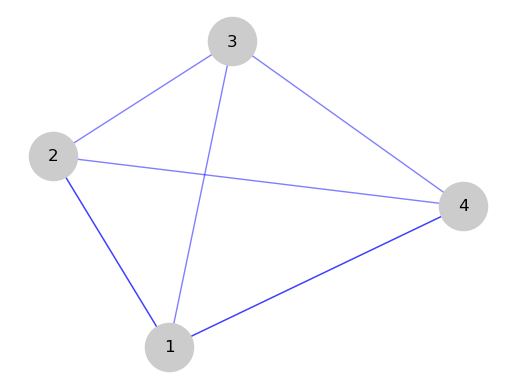

In [6]:
# Let's make a graph - RUN THIS CELL AS IS
G=nx.DiGraph()

G.add_edge("1","2",weight=1)
G.add_edge("1","4",weight=1)
G.add_edge("2","1",weight=1)
G.add_edge("2","3",weight=1)
G.add_edge("2","4",weight=1)
G.add_edge("3","1",weight=1)
G.add_edge("4","1",weight=1)
G.add_edge("4","3",weight=1)

esmall=[(u,v) for (u,v,d) in G.edges(data=True)]

pos=nx.spring_layout(G)

# nodes
nx.draw_networkx_nodes(G,pos,node_size=1200,node_color="#cccccc")
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color='b',arrows=True)

# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')

plt.axis('off')
plt.show() # display

In [7]:
# Sanity check using networkx - RUN THIS CELL AS IS
nx.pagerank(G, alpha=0.85)

{'1': 0.3641543978670252,
 '2': 0.19226533325318493,
 '4': 0.2467404275085557,
 '3': 0.19683984137123423}

### The Power Iteration method produces the steady state vector, which should match the PageRank result above. Or does it?

In [8]:
# Power Iteration helper function - RUN THIS CELL AS IS
import numpy as np
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """ Calculate one eigen vector"""
    state_vector = xInit
    
    for ix in range(nIter):    
        new_state_vector = state_vector@tMatrix
        state_vector = new_state_vector
        
        if verbose:
            print(f'Step {ix}: {state_vector}')
            
    return state_vector

def deflation(tMatrix, eigen_vector):
    #updated_tMatrix = tMatrix - eigen_vector
    updated_tMatrix = None
    return updated_tMatrix
    
def pca(tMatrix, num_of_eigenvectors_reqd):
    for i in range(num_of_eigenvectors_reqd):
        xInit = np.array([1,0,0,0]) 
        eigen_vector = power_iteration(xInit, tMatrix, nIter, verbose = True)
        tMatrix = deflation(tMatrix, eigen_vector)

xInit = np.array([1,0,0,0]) 

 > __DISCUSSION QUESTIONS:__     
For each of the graphs below, answer the following questions:
* Does this matrix converge? On What?
* What could explain this behavior?

### Example 1
<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/web-graph01.png' style="width:30%;">


In [9]:
# Example 1
A = np.array([[0, 1, 0, 1], [1, 0, 1, 1], [1, 0, 0, 0], [1, 0, 1, 0]])
D_1 = np.array([[1/2, 0, 0, 0], [0, 1/3, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1/2]])
Q = D_1@A  #transition matrix

# Change the number of iterations. 
# Set VERBOSE to true to see the output at each iteration
n_iterations = 20
VERBOSE = True
xInit = np.array([1,0,0,0]) 
power_iteration(xInit, Q, n_iterations, verbose=VERBOSE)


Step 0: [0.  0.5 0.  0.5]
Step 1: [0.41666667 0.         0.41666667 0.16666667]
Step 2: [0.5        0.20833333 0.08333333 0.20833333]
Step 3: [0.25694444 0.25       0.17361111 0.31944444]
Step 4: [0.41666667 0.12847222 0.24305556 0.21180556]
Step 5: [0.39178241 0.20833333 0.14872685 0.25115741]
Step 6: [0.34375    0.1958912  0.19502315 0.26533565]
Step 7: [0.39298804 0.171875   0.19796489 0.23717207]
Step 8: [0.37384259 0.19649402 0.1758777  0.25378569]
Step 9: [0.36826855 0.1869213  0.19239085 0.2524193 ]
Step 10: [0.3809076  0.18413428 0.18851675 0.24644137]
Step 11: [0.37311553 0.1904538  0.18459878 0.25183189]
Step 12: [0.37399932 0.18655776 0.18940055 0.25004236]
Step 13: [0.37660765 0.18699966 0.1872071  0.24918558]
Step 14: [0.37413312 0.18830382 0.18692601 0.25063705]
Step 15: [0.37501248 0.18706656 0.18808646 0.2498345 ]
Step 16: [0.37535923 0.18750624 0.18727277 0.24986176]
Step 17: [0.37470573 0.18767962 0.18743296 0.2501817 ]
Step 18: [0.37508368 0.18735286 0.18765072 0.249

array([0.37505804, 0.18754184, 0.18740732, 0.24999279])

### Example 2
<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/web-graph02.png' style="width:30%;">


In [10]:
# Example 2
A = np.array([[0, 1, 1, 1], [1, 0, 1, 1], [0, 0, 0, 0], [1, 0, 1, 0]])
D_1 = np.array([[1/3, 0, 0, 0], [0, 1/3, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1/2]])
Q = D_1@A

# Change the number of iterations. 
# Set VERBOSE to true to see the output at each iteration
n_iterations = 20000
VERBOSE = False

power_iteration(xInit, Q, n_iterations, verbose=VERBOSE)


array([0., 0., 0., 0.])

### Example 3:
<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/web-graph03.png' style="width:30%;">


In [11]:
# Example 3
A = np.array([[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0]])
D_1 = np.array([[1/2, 0, 0, 0], [0, 1/2, 0, 0], [0, 0, 1/2, 0], [0, 0, 0, 1/2]])
Q = D_1@A

# Change the number of iterations. 
# Set VERBOSE to true to see the output at each iteration
n_iterations = 20
VERBOSE = True

power_iteration(xInit, Q, n_iterations, verbose=VERBOSE)


Step 0: [0.  0.5 0.  0.5]
Step 1: [0.5 0.  0.5 0. ]
Step 2: [0.  0.5 0.  0.5]
Step 3: [0.5 0.  0.5 0. ]
Step 4: [0.  0.5 0.  0.5]
Step 5: [0.5 0.  0.5 0. ]
Step 6: [0.  0.5 0.  0.5]
Step 7: [0.5 0.  0.5 0. ]
Step 8: [0.  0.5 0.  0.5]
Step 9: [0.5 0.  0.5 0. ]
Step 10: [0.  0.5 0.  0.5]
Step 11: [0.5 0.  0.5 0. ]
Step 12: [0.  0.5 0.  0.5]
Step 13: [0.5 0.  0.5 0. ]
Step 14: [0.  0.5 0.  0.5]
Step 15: [0.5 0.  0.5 0. ]
Step 16: [0.  0.5 0.  0.5]
Step 17: [0.5 0.  0.5 0. ]
Step 18: [0.  0.5 0.  0.5]
Step 19: [0.5 0.  0.5 0. ]


array([0.5, 0. , 0.5, 0. ])

# Well behaved graphs
#### MIT 6.041 Probabilistic Systems Analysis and Applied Probability   
These lectures go into more detail about Markov Chains, and are a great resource if you want to dig deeper. The examples below were taken from these lectures.

Lecture 16 - Markov Chains Part 1  
https://www.youtube.com/watch?v=IkbkEtOOC1Y

Lecture 17 - Markov Chains Part 2  
https://www.youtube.com/watch?v=ZulMqrvP-Pk

## Primitivity - a graph is primitive if it is irreducible and aperiodic
* [Ergodic Markov Chain](https://www.youtube.com/watch?v=ZjrJpkD3o1w)


### Irreducibility
* A Markov chain is said to be irreducible if its state space is a __single communicating class__; in other words, if it is possible to get to any state from any state.

Why is this important? Let's look at an example from the MIT videos.    

### Recurrent and transient states
<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/irreducibility-02.png' style="width:30%;">


### Does the limit depend on initial state?

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/irreducibility-01.png' style="width:30%;">


### Periodicity
* Well behaved graphs are aperiodic: The GCD (greatest common divisor) of all  cycle lengths is 1. The GCD is also called period.

Why is this important? Again, let's look at an example from the MIT videos.
Remember that the Markov Property of independence says that no matter where we start, the probability of transitioning to a given state does not change. In other words, we have a steady state distribution.

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/periodicity-01.png' style="width:50%;">

If you start at state 2, you have a 50/50 chance of going left or right. There is some randomness, but this randomness is limited. No matter whether you go left or right, you always come back to 2 in the next step. You go out, you go in, you go out, you go in - there is a periodic pattern that gets repeated.

It means that if you start at state 2, after an even number of steps, you are certain to be back at state 2, so the probability is always 1 (for an even number of steps). If the number of transitions is odd, there is no way you can be at state 2. At odd number of steps, you will be at either the left or right, so the probability of being at state 2 is always 0.

As n (number of transitions) goes to infinity, this state 2 probability does not converge to anything. It keeps alternating between 0 and 1.


# Exercise 2
## Is this graph aperiodic?    

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/peridicity-fun-example-01.png' style="width:30%;">


__NO!__
If you start in a purple state, you can only go to a white state, and vs. Again, as N (number of transitions) goes to infinity, the probability of being in the purple or white state does not converge to anything. It keeps alternating between 0 and 1.

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/peridicity-fun-example-02.png' style="width:30%;">

If you are at a purple state, then the probability of going into a white state is 1. But if you are in a white state, then the probability of going to a white state is 0. No matter how many times you walk this graph (ie, ad infinitum), these probabilities will continue to oscillate, and __will never settle on a steady state distribution. Here the initial condition has an influence on the probabilities of being in each state.__

## How can we fix this?


<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/peridicity-fun-example-03.png' style="width:50%;">


A single self loop fixes this. You can now got to any color state in both even and odd number of steps. As the number of iterations approaches infinity, the probabilities converge (they no longer alternate).

## The steady state convergence theorem - Intuition

Think of two copies of the chain that start at different initial states. 

The state moves randomly, and as the state moves around randomly starting from the two initial states, on a random trajectory… as long as you have a single recurrent class, and you don’t have periodicity, at some point those two states (those trajectories) are going to collide. Just because there’s enough randomness there. After the state becomes the same, the future of those trajectories, probabilistically, is the same, because they both started in the same state.

So this means that the initial conditions stopped having any influence.


## Stochasticity - a graph is stochastic if all rows sum to 1

### Perron-Frobenius Theorem:
Any __irreducible, aperiodic, stochastic__ matrix $P$ has an eigenvalue $\lambda_0 = 1$ with unique associated left eigenvector $e_0 > 0$. Moreover, all other eigenvalues $\lambda_i$ of $P$ satisfy $|\lambda_i| < 1$.

# Connecting the dots: 
## Random Surfer -> Markov  Process -> PageRank

Adapting the machinery of the Markov processes gives us a principled approach to calculate the pagerank of each webpage. 
It is nothing more than  the steady state probability distribution of the  markov process underlying the random surfer model of web navigation.


__PageRank__ is a link analysis algorithm that  "measures” relative importance of each page within  the webgraph.
$v_0P = v_0$

## But... is the web-graph well behaved?

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/web-graph-01.png' style="width:50%;" align="left">


## Adjustments for PageRank

* Random Jump factor adds a small amount of probability to each node to teleport to any other node.
* Both issues of periodicity and irreducibility are solved at once.

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/web-graph.png' style="width:100%;" align="left">


# PageRank at Scale

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/week10/PR-illustration.png' style="width:`100%;" align="left">


$$
P^T = (1-\alpha)\big(\frac{m}{|G|} + P'\big) + \alpha \frac{1}{|G|} 
$$


Just like Single Source Shortest Path, this is an iterative algorithm that requires that we maintain the entire graph structure at each iteration. 



### Optimization
Custom partitioning - how can we leverage custom partitioning to speed up PageRank? http://stanford.edu/~rezab/dao/notes/Partitioning_PageRank.pdf

# PageRank in PySpark

In [12]:

# Licensed to the Apache Software Foundation (ASF) under one or more
# contributor license agreements.  See the NOTICE file distributed with
# this work for additional information regarding copyright ownership.
# The ASF licenses this file to You under the Apache License, Version 2.0
# (the "License"); you may not use this file except in compliance with
# the License.  You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Adapted from https://github.com/apache/spark/blob/master/examples/src/main/python/pagerank.py

"""
This is an example implementation of PageRank. For more conventional use,
Please refer to PageRank implementation provided by graphx
"""
import re
import sys
from operator import add
from typing import Mapping,Tuple
from pyspark.resultiterable import ResultIterable
from pyspark.sql import SparkSession


def computeContribs(urls, rank): # -> Iterable[Tuple[str, float]]:
    """Calculates URL contributions to the rank of other URLs."""
    num_urls = len(urls)
    for url in urls:
        yield (url, rank / num_urls)


def parseNeighbors(urls: str) -> Tuple[str, str]:
    """Parses a urls pair string into urls pair."""
    parts = re.split(r'\s+', urls)
    return parts[0], parts[1]


def page_rank_test_run(iterations =50):
     
    # Loads in input data. It should be in format of:
    #     URL         neighbor URL
    #     URL         neighbor URL
    #     URL         neighbor URL
    #     ...
    # Page graph
    links = """1 2
1 3
1 4
2 1
4 1"""
    lines = sc.parallelize(list(links.split("\n")))
   
    # Loads all URLs from input file and initialize their neighbors.
    links = lines.map(lambda urls: parseNeighbors(urls)).distinct().groupByKey().cache()

    # Loads all URLs with other URL(s) link to from input file and initialize ranks of them to one.
    ranks = links.map(lambda url_neighbors: (url_neighbors[0], 1.0))

    # Calculates and updates URL ranks continuously using PageRank algorithm.
    for iteration in range(iterations):
        # Calculates URL contributions to the rank of other URLs.
        contribs = links.join(ranks).flatMap(lambda url_urls_rank: computeContribs(
            url_urls_rank[1][0], url_urls_rank[1][1]  # type: ignore[arg-type]
        ))
        # Calculate the dangling node mass
        # your code goes here
        
        
        # Re-calculates URL ranks based on neighbor contributions.
        ranks = contribs.reduceByKey(add).mapValues(lambda rank: rank * 0.85 + 0.15)

    # Collects all URL ranks and dump them to console.
    for (link, rank) in ranks.collect():
        print("%s has rank: %s." % (link, rank))

page_rank_test_run()

22/10/24 19:33:38 WARN org.apache.spark.storage.BlockManager: Block rdd_9_0 already exists on this machine; not re-adding it


2 has rank: 0.3713826440188872.
1 has rank: 0.7813504848761346.
4 has rank: 0.3713826440188872.
3 has rank: 0.3713826440188872.


## TASK Debug the above implementation 

## TASK implement the above example using  graphframes

## Does your homemade implementation match the graphframes results?
Explain.

# Well behaved graphs
#### MIT 6.041 Probabilistic Systems Analysis and Applied Probability   
These lectures go into more detail about Markov Chains, and are a great resource if you want to dig deeper. The examples below were taken from these lectures.

Lecture 16 - Markov Chains Part 1  
https://www.youtube.com/watch?v=IkbkEtOOC1Y

Lecture 17 - Markov Chains Part 2  
https://www.youtube.com/watch?v=ZulMqrvP-Pk

------------------------------------------------------------

# Extensions

### Personalized PageRank
Markov models have also been used to analyze web navigation behavior of users. A user's web link transition on a particular website can be modeled using first- or second-order Markov models and can be used to make predictions regarding future navigation and to personalize the web page for an individual user.

### Topic Specific PageRank
### TextRank
### PCA/SVD

# Going Further

### Google Knowledge Graph
https://en.wikipedia.org/wiki/Knowledge_Graph

### Scalable Graph Processing Frameworks: A Taxonomy and Open Challenges
http://www.buyya.com/papers/GraphProcessing-ACMCS.pdf

## GraphFrames examples

In [13]:
from functools import reduce
from pyspark.sql.functions import col, lit, when
from graphframes import *
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

In [14]:
vertices = sqlContext.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "Gabby", 60)], ["id", "name", "age"])

In [15]:
edges = sqlContext.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])

In [16]:
from graphframes.examples import Graphs
same_g = Graphs(sqlContext).friends()
print(same_g)

GraphFrame(v:[id: string, name: string ... 1 more field], e:[src: string, dst: string ... 1 more field])


In [17]:
g = GraphFrame(vertices, edges)
print(g)

GraphFrame(v:[id: string, name: string ... 1 more field], e:[src: string, dst: string ... 1 more field])


In [18]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
+---+-------+---+



In [19]:
g.inDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  f|       1|
|  e|       1|
|  d|       1|
|  c|       2|
|  b|       2|
|  a|       1|
+---+--------+



In [20]:
youngest = g.vertices.groupBy().min("age")
youngest.show()

+--------+
|min(age)|
+--------+
|      29|
+--------+



In [21]:
paths = g.bfs("name = 'Esther'", "age < 32")
paths.show()

+---------------+--------------+--------------+
|           from|            e0|            to|
+---------------+--------------+--------------+
|{e, Esther, 32}|{e, d, friend}|{d, David, 29}|
+---------------+--------------+--------------+



In [23]:
%%time
results = g.pageRank(resetProbability=0.15, tol=0.01)
results.vertices.show()

22/10/24 19:40:26 WARN org.apache.spark.storage.BlockManager: Block rdd_1188_1 already exists on this machine; not re-adding it


+---+-------+---+-------------------+
| id|   name|age|           pagerank|
+---+-------+---+-------------------+
|  g|  Gabby| 60| 0.1799821386239711|
|  b|    Bob| 36|  2.655507832863289|
|  e| Esther| 32|0.37085233187676075|
|  a|  Alice| 34|0.44910633706538744|
|  f|  Fanny| 36| 0.3283606792049851|
|  d|  David| 29| 0.3283606792049851|
|  c|Charlie| 30| 2.6878300011606218|
+---+-------+---+-------------------+

CPU times: user 111 ms, sys: 27.3 ms, total: 138 ms
Wall time: 32.7 s
